In [1]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.models import Model, Sequential
import tensorflow.keras.applications as m
from keras import layers
from keras.datasets.cifar10 import load_data
from keras.utils.layer_utils import count_params
from keras.optimizer_v2.adam import Adam
from tensorflow.keras.utils import to_categorical

from typing import Any, Callable, Tuple

from keras_models import get_base_model
from lt_models import build_model, unfreeze_model
from utils import plot_history, plot_confusion_matrix, load_dataset, get_data_generators

In [3]:
(x_train, y_train), (x_test, y_test), key = load_dataset('fmnist')

In [4]:
top_layers = [
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')
]
model, base_model = build_model(
    model_name='resnet50', 
    input_shape=(32, 32), 
    top_layers=top_layers, 
    lr=1e-3
)
model.summary()

Model: "resnet50_transfer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 32, 32, 3)         0         
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)          

In [5]:
initial_epochs = 2
fine_tune_epochs = 1

In [6]:
def augmentation_layer(x: tf.Tensor) -> tf.Tensor:
    x = tf.cast(x, dtype=tf.float32)
    # x = tf.image.random_brightness(x, 0.1)
    # x = tf.image.random_contrast(x, 0, 0.1)
    x = tf.image.random_flip_left_right(x)

    return x

train_dataset, test_dataset = get_data_generators(x_train, y_train, x_test, y_test, augmentation_layer)


In [7]:
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=test_dataset,
)

Epoch 1/2
469/469 [==============================] - 130s 180ms/step - loss: 0.9886 - accuracy: 0.7072 - val_loss: 0.4725 - val_accuracy: 0.8246
Epoch 2/2
469/469 [==============================] - 79s 167ms/step - loss: 0.5139 - accuracy: 0.8099 - val_loss: 0.4355 - val_accuracy: 0.8376


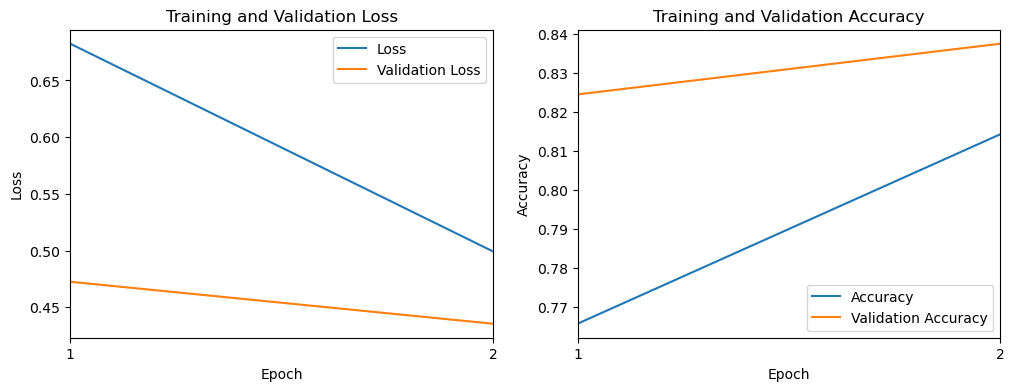

In [8]:
plot_history(history)

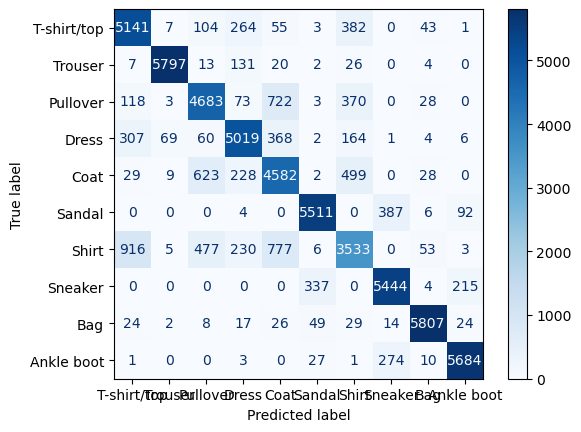

In [9]:
labels = [val for val in key.values()]
plot_confusion_matrix(model, x_train, y_train, labels)

In [10]:
unfreeze_model(model, base_model, 200, 1e-5)
model.compile(
    optimizer=Adam(learning_rate=1e-5), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
model.summary()

Model: "resnet50_transfer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 32, 32, 3)         0         
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)          

In [11]:
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=test_dataset
)

Epoch 2/3
469/469 [==============================] - 269s 514ms/step - loss: 1.8231 - accuracy: 0.4781 - val_loss: 0.7267 - val_accuracy: 0.7339
Epoch 3/3
469/469 [==============================] - 212s 450ms/step - loss: 0.6255 - accuracy: 0.7779 - val_loss: 0.4790 - val_accuracy: 0.8296


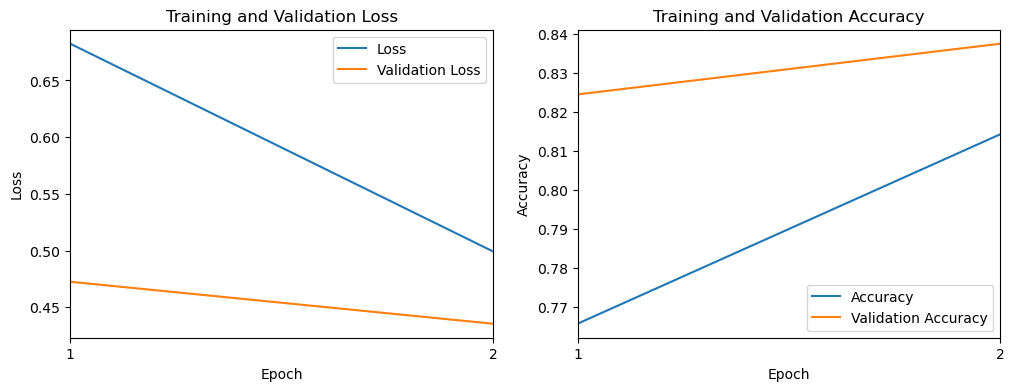

In [12]:
plot_history(history)

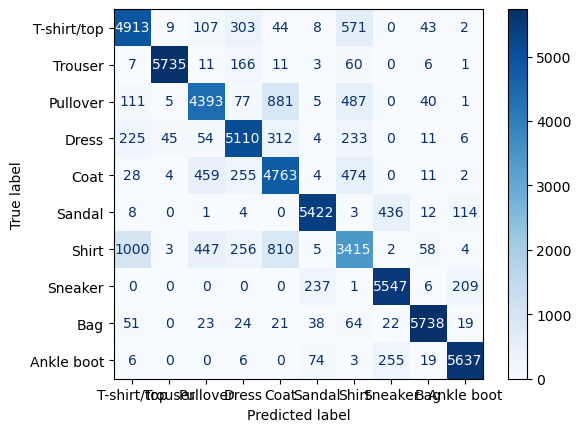

In [13]:
labels = [val for val in key.values()]
plot_confusion_matrix(model, x_train, y_train, labels)